# 加载模型

此处如果是已经下载到本地的模型，加载时报jina-embeddings-v2-base-en加载时报Could not locate the configuration_bert.py inside jinaai/jina-bert-implementation，可以修改jina-embeddings-v2-base-en下的config.json文件，替换auto_map下的四个类映射的路径中的jinaai/jina-bert-implementation为本地绝对路径


In [1]:
from transformers import AutoModel
from transformers import AutoTokenizer

# 为了保持与官方代码一致，此处使用这个模型
model_path = 'jinaai/jina-embeddings-v2-base-en'

tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
model = AutoModel.from_pretrained(model_path, trust_remote_code=True)

In [2]:
import os
import pandas as pd

In [3]:
import sys

In [4]:
sys.path.append('late-chunking')

In [5]:
from chunked_pooling import chunked_pooling, chunk_by_sentences

此处以wikipedia上拷贝的DeepSeek的文本为例进行分析

In [6]:
input_text = open(os.path.join('data', 'deepseek_wiki.txt')).read()

In [7]:
len(input_text)

8551

In [8]:
chunks, span_annotations = chunk_by_sentences(input_text, tokenizer)

In [9]:
len(chunks)

32

In [10]:
inputs = tokenizer(input_text, return_tensors='pt')
model_output = model(**inputs)
embeddings = chunked_pooling(model_output, [span_annotations])[0]

整个embeddings，就是Late Chunking后的embedding

In [11]:
len(embeddings)

32

# 计算相似度

将每个片段作为Query，然后与Late Chunking之后片段的Embedding计算余弦相似度

In [12]:
import numpy as np

cos_sim = lambda x, y: np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [13]:
single_chunk_embeds = np.array([model.encode(chunk) for chunk in chunks])

In [14]:
single_chunk_embeds.shape

(32, 768)

In [15]:
# 不能用这个计算，不是单位向量
# dot_products = np.dot(embeddings, single_chunk_embeds.T)

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

In [17]:
cos_sim = cosine_similarity(embeddings, single_chunk_embeds)

In [18]:
cos_sim.shape

(32, 32)

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: >

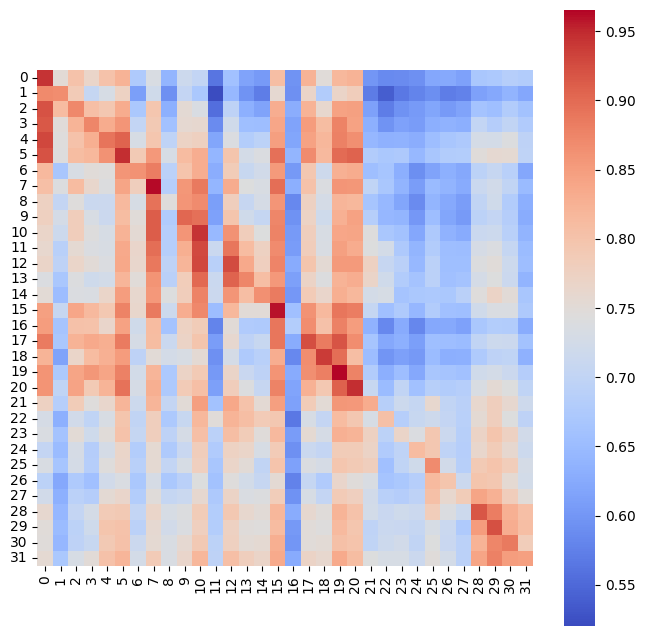

In [20]:
plt.figure(figsize=(8, 8))

sns.heatmap(cos_sim, square=True, cmap='coolwarm')

从这个结果来看，最相似的片段，并不总是自己，前5个句子，似乎都跟第一个句子最相似

# 观察那些不与自己最相似的片段的特征

由于Late Chunking是将整个片段每个位置的hidden state做平均，所以可以想想，短句、代词较多的句子，应该会跟其他句子更相似。简便起见，此处检查句子长度

In [21]:
data = []
for idx in range(cos_sim.shape[0]):
    data.append({
        'idx': idx,
        'most_sim_idx': cos_sim[idx].argmax(),
        'chunk_len': len(chunks[idx])
    })

In [22]:
cos_sim_df = pd.DataFrame(data)
cos_sim_df['self_most_sim'] = (cos_sim_df['idx'] == cos_sim_df['most_sim_idx']).astype(int)

In [23]:
cos_sim_df

,idx,most_sim_idx,chunk_len,self_most_sim
0,0,0,210,1
1,1,0,90,0
2,2,0,121,0
3,3,0,91,0
4,4,0,228,0
5,5,5,861,1
6,6,7,182,0
7,7,7,497,1
8,8,7,65,0
9,9,7,164,0


In [24]:
cos_sim_df['self_most_sim'].mean()

0.4375

<Axes: xlabel='self_most_sim', ylabel='chunk_len'>

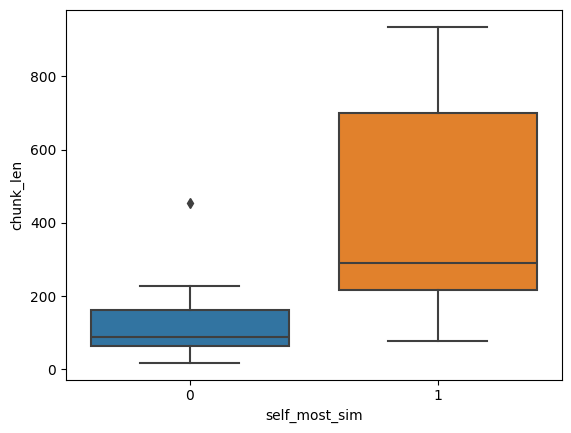

In [25]:
sns.boxplot(x='self_most_sim', y='chunk_len', data=cos_sim_df)

从结论可以看出，长度较短的句子都不与自己最相似

# case分析

In [26]:
cos_sim_df[cos_sim_df['self_most_sim'] == 0]

,idx,most_sim_idx,chunk_len,self_most_sim
1,1,0,90,0
2,2,0,121,0
3,3,0,91,0
4,4,0,228,0
6,6,7,182,0
8,8,7,65,0
9,9,7,164,0
11,11,10,64,0
12,12,10,454,0
13,13,12,159,0


In [27]:
for idx, row in cos_sim_df.iterrows():
    if row['idx'] == row['most_sim_idx']:
        continue
    print(f"idx={row['idx']}, most sim idx={row['most_sim_idx']}")
    print(f"chunks['idx']: {chunks[row['idx']]}")
    print(f"chunks['most_sim_idx']: {chunks[row['most_sim_idx']]}")
    print('\n')

    if idx >= 5:
        break

idx=1, most sim idx=0
chunks['idx']:  Based in Hangzhou, Zhejiang, it is owned and funded by the Chinese hedge fund High-Flyer.
chunks['most_sim_idx']: Hangzhou DeepSeek Artificial Intelligence Basic Technology Research Co., Ltd.,[2][3][4][a] doing business as DeepSeek,[b] is a Chinese artificial intelligence company that develops large language models (LLMs).


idx=2, most sim idx=0
chunks['idx']:  DeepSeek was founded in July 2023 by High-Flyer co-founder Liang Wenfeng, who also serves as the CEO for both companies.
chunks['most_sim_idx']: Hangzhou DeepSeek Artificial Intelligence Basic Technology Research Co., Ltd.,[2][3][4][a] doing business as DeepSeek,[b] is a Chinese artificial intelligence company that develops large language models (LLMs).


idx=3, most sim idx=0
chunks['idx']:  The company launched an eponymous chatbot alongside its DeepSeek-R1 model in January 2025.
chunks['most_sim_idx']: Hangzhou DeepSeek Artificial Intelligence Basic Technology Research Co., Ltd.,[2][3][4

这个结果看起来问题应该还是比较大的，例如对于idx=1的句子“Based in Hangzhou, Zhejiang, it is owned and funded by the Chinese hedge fund High-Flyer.“，这句话跟它本身不是最相似的，而是跟”Hangzhou DeepSeek Artificial Intelligence Basic Technology Research Co., Ltd.,[2][3][4][a] doing business as DeepSeek,[b] is a Chinese artificial intelligence company that develops large language models (LLMs).“最相似